In [2]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

#### census data

In [3]:
census_path = '../Project 1/census/'

In [4]:
with open(os.path.join(census_path, 'adult.names')) as f:
    names = f.readlines()
cols = [c for c in names if c[0] != '|']
cols = [c.replace('\n', '') for c in cols]
cols = [c.split(':')[0] for c in cols]
cols = [c for c in cols if c]
cols = cols[1:] + [cols[0]]
df_census = pd.read_csv(os.path.join(census_path, 'adult.data'), names=cols)

In [5]:
X_census_cols = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
    'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'
]
categorical_cols = [
    'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'
]
X_census = pd.get_dummies(df_census[X_census_cols], columns=categorical_cols, drop_first=True)
y_census = df_census['>50K, <=50K.'].map(lambda x: {'>50K': 1, '<=50K': 0}.get(x.strip()))

In [6]:
X_census_train, X_census_test, y_census_train, y_census_test = train_test_split(
    X_census, y_census, stratify=y_census, train_size=.8, shuffle=True, random_state=42
)

In [7]:
ss = StandardScaler()
x_cols = X_census.columns
X_census_train = ss.fit_transform(X_census_train)
X_census_test = ss.transform(X_census_test)

#### spam data

In [8]:
spam_path = '../Project 1/spam/spambase.data'

In [9]:
df_spam = pd.read_csv(spam_path, header=None)

In [10]:
X_spam_cols = df_spam.columns[:-1]
y_spam_col = df_spam.columns.difference(X_spam_cols)[0]
X_spam = df_spam[X_spam_cols]
y_spam = df_spam[y_spam_col]

In [11]:
X_spam_train, X_spam_test, y_spam_train, y_spam_test = train_test_split(
    X_spam, y_spam, stratify=y_spam, train_size=.8, shuffle=True, random_state=42
)

In [12]:
ss = StandardScaler()
x_cols = X_spam.columns
X_spam_train = ss.fit_transform(X_spam_train)
X_spam_test = ss.transform(X_spam_test)

#### distances

In [13]:
path = './dist_census.csv'
if not os.path.isfile(path):
    dist_census = distance_matrix(X_census_train, X_census_train)
    np.savetxt(path, dist_census, delimiter=',')
else:
    print('Loading Census Distance')
    dist_census = np.loadtxt(path, delimiter=',')

Loading Census Distance


In [14]:
path = './dist_spam.csv'
if not os.path.isfile(path):
    dist_spam = distance_matrix(X_spam_train, X_spam_train)
    np.savetxt(path, dist_spam, delimiter=',')
else:
    print('Loading Spam Distance')
    dist_spam = np.loadtxt(path, delimiter=',')

Loading Spam Distance


#### visualize cluster

In [15]:
def viz_clusters(X, clusters, i=0, j=1):
    pca = PCA()
    x = pca.fit_transform(X)
    x1 = x[:, i]
    x2 = x[:, j]
    fig, ax = plt.subplots(figsize=(16,9))
    plot = ax.scatter(x1, x2, c=clusters, alpha=.2)
    var1 = round(pca.explained_variance_ratio_[i], 2)
    var2 = round(pca.explained_variance_ratio_[j], 2)
    ax.set_xlabel(f'PCA Component {i} - Percent Explained Variance {var1}')
    ax.set_ylabel(f'PCA Component {j} - Percent Explained Variance {var2}')
    leg = ax.legend(*plot.legend_elements())
    for lh in leg.legendHandles:
        lh._legmarker.set_alpha(1)

In [16]:
def elbow_plot(scores, metric, figsize=(5,3)):
    scores = pd.Series(scores)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(scores.index, scores.values)
    ax.set_title('Elbow Plot')
    ax.set_ylabel(metric.title())
    ax.set_xlabel('K')

In [17]:
def calc_silhouette(d, c, alg):
    if alg == 'soft':
        n, m = c.shape
        scores = np.zeros(c.shape)
        for i in range(m):
            a = (d * c[:, i]).sum(axis=1) / np.dot(1-np.eye(n), c[:,i])
            b = np.zeros((n, m-1))
            for j in range(m):
                if i == j:
                    continue
                idx = j - (1 * (j > i))
                b[:, idx] = (d * c[:, j]).sum(axis=1) / np.dot(1-np.eye(n), c[:,j])
            b = b.min(axis=1)
            scores[:, i] = (b - a)/np.array([a, b]).max(axis=0)
        score = (scores * c).sum() / c.sum()
    elif alg == 'hard':
        if len(c.shape) > 1:
            if c.shape[1] > 1:
                c = c.argmax(axis=1)
            elif c.shape[1] == 1:
                c = c.reshape(-1)
        score = silhouette_score(d, c, metric='precomputed')
    return score

#### results prep

In [18]:
results = {
    'em_census': {'log_likelihood': '', 'final': {'silhouette': '', 'information_gain': ''}},
    'km_census': {'silhouette': '', 'final': {'silhouette': '', 'information_gain': ''}},
    'em_spam': {'log_likelihood': '', 'final': {'silhouette': '', 'information_gain': ''}},
    'km_spam': {'silhouette': '', 'final': {'silhouette': '', 'information_gain': ''}}
}

#### clustering - EM census

In [19]:
X = X_census_train.copy()
y = y_census_train.copy()
X_val = X_census_test.copy()
dist = dist_census
model = GaussianMixture
alg = 'soft'
fname = 'em_census.csv'

In [20]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict_proba(X)
    cols = [f'{k}_{i}' for i in range(k)]
    for i, col in enumerate(cols):
        df[col] = y_pred[:, i]

In [21]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

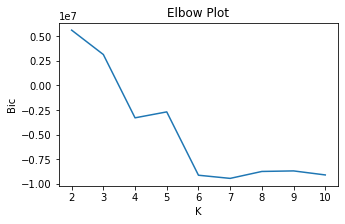

In [22]:
# choose k - BIC
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].bic(X)
elbow_plot(scores, 'BIC')

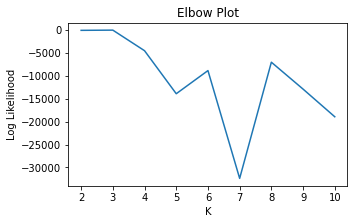

In [23]:
# choose k - log likelihood
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].score(X_val)
results[fname.replace('.csv', '')]['log_likelihood'] = scores
elbow_plot(scores, 'Log Likelihood')

In [24]:
# elbow_plot(sil_scores, 'silhouette')

In [25]:
pd.concat([df.filter(like='3_').mean(), df.filter(like='3_').idxmax(axis=1).value_counts(normalize=True)], axis=1)

,0,1
3_0,0.033630,0.033630
3_1,0.490188,0.490172
3_2,0.476182,0.476198


In [26]:
pd.concat([df.filter(like='2_').mean(), df.filter(like='2_').idxmax(axis=1).value_counts(normalize=True)], axis=1)

,0,1
2_0,0.03363,0.03363
2_1,0.96637,0.96637


In [27]:
# choose k
k = 3
alt_k = 2
k_cols = df.filter(like=f'{k}_').columns
alt_k_cols = df.filter(like=f'{alt_k}_').columns

In [28]:
# validate - silhouette
sil = calc_silhouette(dist, df[k_cols].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

0.051768229344196164

In [29]:
calc_silhouette(dist, df[alt_k_cols].values, alg)

0.08634844457217968

In [30]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print((df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()).round(3))

0.241 

3_0    0.240
3_1    0.058
3_2    0.429
dtype: float64


In [31]:
print(round(df['label'].mean(), 3), '\n')
print((df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()).round(3))

0.241 

2_0    0.240
2_1    0.241
dtype: float64


In [32]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()
q = df[k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k_cols].mean()).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

0.14309161230973166

In [33]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()
q = df[alt_k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[alt_k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k_cols].mean()).sum()
ig = h1 - h2
ig

1.6588474305301304e-07

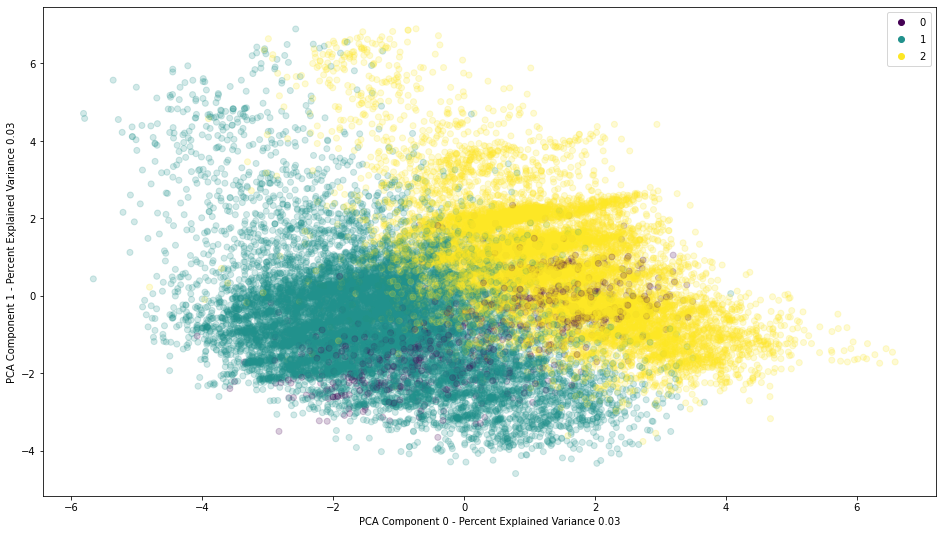

In [34]:
# visualize clusters
viz_clusters(X, df[k_cols].idxmax(axis=1).map(lambda x: x[2:]).astype(int))

#### clustering - K Means census

In [35]:
X = X_census_train.copy()
y = y_census_train.copy()
X_val = X_census_test.copy()
dist = dist_census
model = KMeans
alg = 'hard'
fname = 'km_census.csv'

In [36]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict(X)
    col = k
    df[col] = y_pred

In [37]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

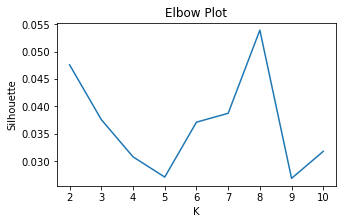

In [38]:
# choose k - silhouette
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = silhouette_score(dist, df[k], metric='precomputed')
results[fname.replace('.csv', '')]['silhouette'] = scores
elbow_plot(scores, 'Silhouette')

In [39]:
df[8].value_counts(normalize=True)

7    0.398034
5    0.225046
3    0.142314
4    0.099893
1    0.061080
2    0.042460
0    0.030943
6    0.000230
Name: 8, dtype: float64

In [40]:
df[2].value_counts(normalize=True)

1    0.521537
0    0.478463
Name: 2, dtype: float64

In [41]:
# choose k
k = 8
alt_k = 2
k_cols = df.filter(like=f'{k}').columns
alt_k_cols = df.filter(like=f'{alt_k}').columns

In [42]:
# validate - silhouette
sil = calc_silhouette(dist, df[k].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

0.05391429668120112

In [43]:
calc_silhouette(dist, df[alt_k].values, alg)

0.04757647452598117

In [44]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(k)['label'].mean().round(3))

0.241 

8
0    0.293
1    0.121
2    0.066
3    0.010
4    0.067
5    0.113
6    0.000
7    0.472
Name: label, dtype: float64


In [45]:
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(alt_k)['label'].mean().round(3))

0.241 

2
0    0.444
1    0.055
Name: label, dtype: float64


In [46]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k].value_counts(normalize=True)).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

/Users/dan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.16307160375556395

In [47]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(alt_k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k].value_counts(normalize=True)).sum()
ig = h1 - h2
ig

0.16273563210113717

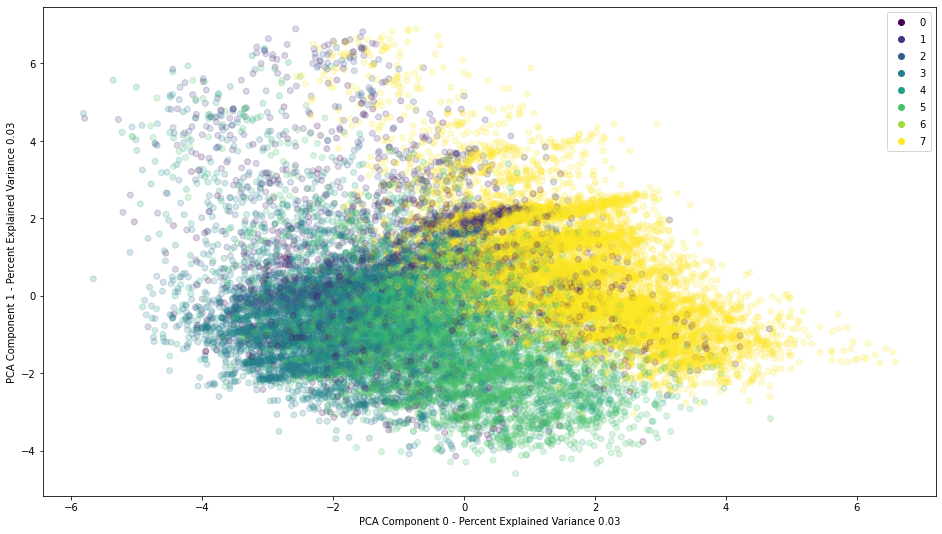

In [48]:
# visualize clusters
viz_clusters(X, df[k])

#### clustering - EM spam

In [49]:
X = X_spam_train.copy()
y = y_spam_train.copy()
X_val = X_spam_test.copy()
dist = dist_spam
model = GaussianMixture
alg = 'soft'
fname = 'em_spam.csv'

In [50]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict_proba(X)
    cols = [f'{k}_{i}' for i in range(k)]
    for i, col in enumerate(cols):
        df[col] = y_pred[:, i]

In [51]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

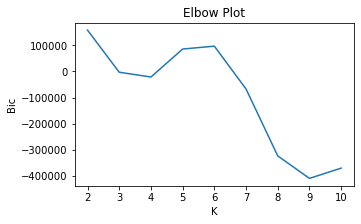

In [52]:
# choose k - BIC
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].bic(X)
elbow_plot(scores, 'BIC')

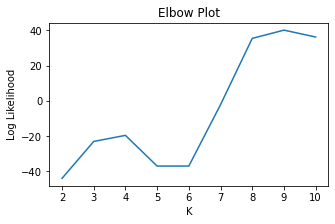

In [53]:
# choose k - log likelihood
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].score(X_val)
results[fname.replace('.csv', '')]['log_likelihood'] = scores
elbow_plot(scores, 'Log Likelihood')

In [54]:
pd.concat([df.filter(like='9_').mean(), df.filter(like='9_').idxmax(axis=1).value_counts(normalize=True)], axis=1)

,0,1
9_0,0.070652,0.070652
9_1,0.028533,0.028533
9_2,0.091283,0.091304
9_3,0.122826,0.122826
9_4,0.038320,0.038315
9_5,0.105211,0.105707
9_6,0.217625,0.217120
9_7,0.036136,0.036141
9_8,0.289414,0.289402


In [55]:
pd.concat([df.filter(like='8_').mean(), df.filter(like='8_').idxmax(axis=1).value_counts(normalize=True)], axis=1)

,0,1
8_0,0.099185,0.099185
8_1,0.029886,0.029891
8_2,0.331313,0.330707
8_3,0.123641,0.123641
8_4,0.038320,0.038315
8_5,0.192276,0.192935
8_6,0.149241,0.149185
8_7,0.036136,0.036141


In [56]:
# choose k
k = 8
alt_k = 9
k_cols = df.filter(like=f'{k}_').columns
alt_k_cols = df.filter(like=f'{alt_k}_').columns

In [57]:
# validate - silhouette
sil = calc_silhouette(dist, df[k_cols].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

0.008045377110686763

In [58]:
calc_silhouette(dist, df[alt_k_cols].values, alg)

-0.0036642126716740333

In [59]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print((df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()).round(3))

0.394 

8_0    0.304
8_1    0.982
8_2    0.889
8_3    0.145
8_4    0.050
8_5    0.064
8_6    0.047
8_7    0.023
dtype: float64


In [60]:
print(round(df['label'].mean(), 3), '\n')
print((df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()).round(3))

0.394 

9_0    0.200
9_1    0.981
9_2    0.783
9_3    0.144
9_4    0.050
9_5    0.059
9_6    0.045
9_7    0.023
9_8    0.843
dtype: float64


In [61]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()
q = df[k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k_cols].mean()).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

0.5109237766015247

In [62]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()
q = df[alt_k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[alt_k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k_cols].mean()).sum()
ig = h1 - h2
ig

0.48092922818281

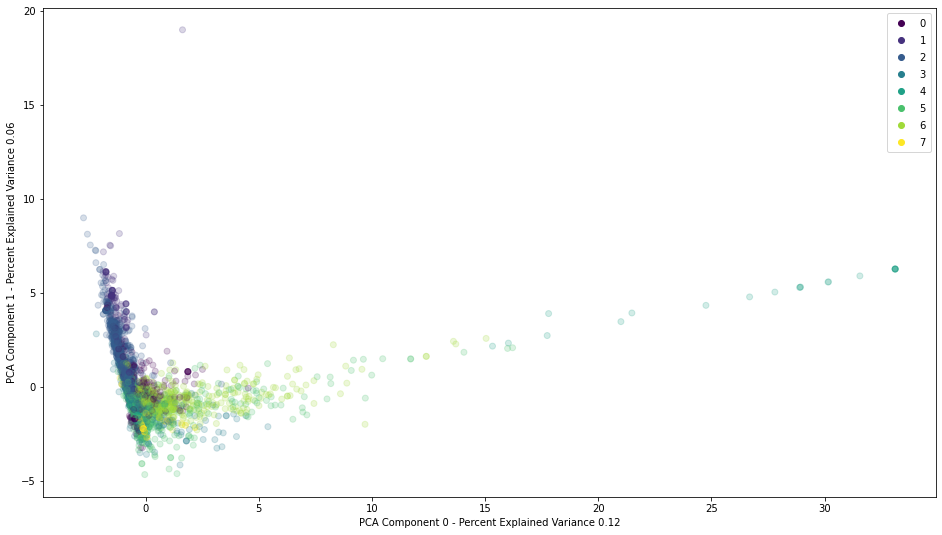

In [63]:
# visualize clusters
viz_clusters(X, df[k_cols].idxmax(axis=1).map(lambda x: x[2:]).astype(int))

#### clustering - K Means spam

In [64]:
X = X_spam_train.copy()
y = y_spam_train.copy()
X_val = X_spam_test.copy()
dist = dist_spam
model = KMeans
alg = 'hard'
fname = 'km_spam.csv'

In [65]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict(X)
    col = k
    df[col] = y_pred

In [66]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

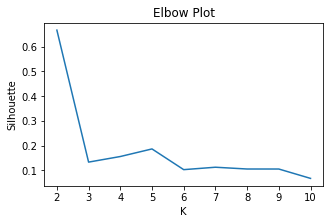

In [67]:
# choose k - silhouette
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = silhouette_score(dist, df[k], metric='precomputed')
results[fname.replace('.csv', '')]['silhouette'] = scores
elbow_plot(scores, 'Silhouette')

In [68]:
df[2].value_counts(normalize=True)

1    0.992663
0    0.007337
Name: 2, dtype: float64

In [69]:
df[5].value_counts(normalize=True)

4    0.696739
2    0.187772
3    0.098098
0    0.010054
1    0.007337
Name: 5, dtype: float64

In [70]:
# choose k
k = 5
alt_k = 2
k_cols = df.filter(like=f'{k}').columns
alt_k_cols = df.filter(like=f'{alt_k}').columns

In [71]:
# validate - silhouette
sil = calc_silhouette(dist, df[k].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

0.18677403420849992

In [72]:
calc_silhouette(dist, df[alt_k].values, alg)

0.6670658780132899

In [73]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(k)['label'].mean().round(3))

0.394 

5
0    0.000
1    0.000
2    0.932
3    0.019
4    0.312
Name: label, dtype: float64


In [74]:
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(alt_k)['label'].mean().round(3))

0.394 

2
0    0.000
1    0.397
Name: label, dtype: float64


In [75]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k].value_counts(normalize=True)).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

/Users/dan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.26288774598059605

In [76]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(alt_k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k].value_counts(normalize=True)).sum()
ig = h1 - h2
ig

0.005327553695325116

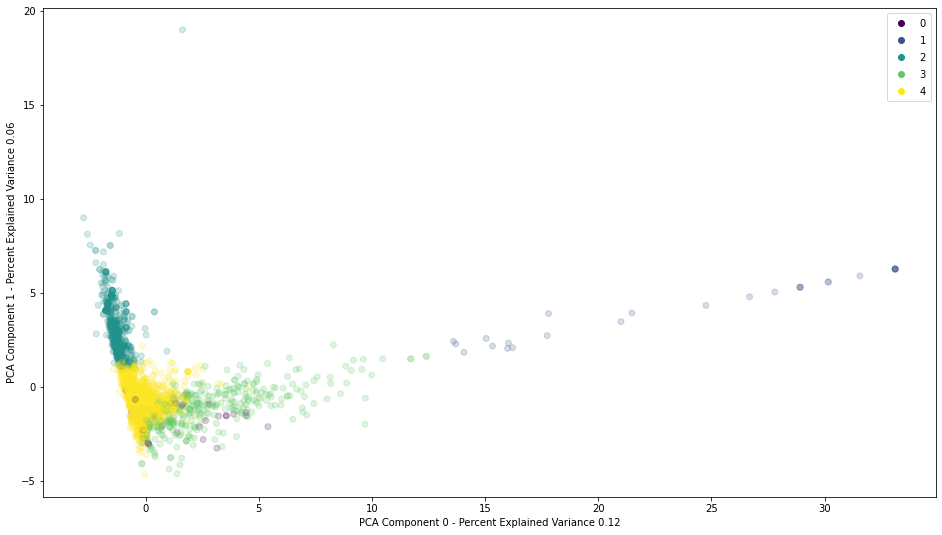

In [77]:
# visualize clusters
viz_clusters(X, df[k])

#### saving

In [78]:
for name, model_results in results.items():
    path = f'./results/{name}'
    for results_name, data in model_results.items():
        full_path = f'{path}_{results_name}.csv'
        if isinstance(data, pd.DataFrame):
            data.to_csv(full_path)
        elif isinstance(data, dict):
            pd.DataFrame(data, index=[0]).to_csv(full_path)